In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Class for simple Linear classifier

In [3]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=2):
        super(LinearClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x

Defines a function that has input a binary linear classifier's weights and biases, and outputs the decision boundary line in [-4,4] * [-4,4]

In [4]:
def plot_db(w0, w1, b0, b1, modelType='[modelType]', lins='r'):

    x0 = np.linspace(-4,4,100)
    x1 = (b1 - b0 - (w0[0] - w1[0]) * x0) / (w0[1] - w1[1])
    plt.plot(x0, x1, lins, label=f'{modelType}')

### Synthetic data generation and visualisation

10,000 samples - 95% from Gaussian centered at (-1, -1) with covariance I; the remaining 5% from Gaussian centered at (1, 1) with covariance I.

In [5]:
N = 10000

class_prob = [0.95, 0.05]
class_freq = [int(N * i) for i in class_prob]

covariance = np.identity(2) * 0.04
np.random.seed(2022)
sampA = np.random.multivariate_normal([-1,-1], covariance, class_freq[0])
sampB = np.random.multivariate_normal([1,1], covariance, class_freq[1])
np.random.seed()

X_values = np.concatenate((sampA, sampB), axis=0)
y_flat = np.array([0] * class_freq[0] + [1] * class_freq[1])

index_shuffle = np.arange(len(X_values))
np.random.shuffle(index_shuffle)

X_values = X_values[index_shuffle]
y_flat = y_flat[index_shuffle]

X_train = torch.tensor(X_values).type(torch.FloatTensor)
y_train = torch.from_numpy(y_flat).view(-1,1).type(torch.LongTensor)

### Training the standard classifier 

With single layer NN with Cross-Entropy Loss (for binary classification equivalent to a sigmoid classifier)

In [6]:
model_bin_orig = LinearClassifier()

In [7]:
model_bin = deepcopy(model_bin_orig)
optimizer_bin = torch.optim.SGD(model_bin.parameters(), lr=0.1, weight_decay=0)
criterion_bin = torch.nn.CrossEntropyLoss()

In [8]:
def modelTrain(model, optimizer, criterion):
    for epoch in range(10000):
    
        # zero the gradients
        optimizer.zero_grad()

        # forward
        output = model(X_train)
        loss = criterion(output, y_train.view(-1))

        # backward
        loss.backward()

        # optimize
        optimizer.step()

In [9]:
modelTrain(model_bin, optimizer_bin, criterion_bin)

In [10]:
w0 = model_bin.linear.weight[0].detach().numpy()
w1 = model_bin.linear.weight[1].detach().numpy()
b0 = model_bin.linear.bias[0].detach().numpy()
b1 = model_bin.linear.bias[1].detach().numpy()

### Reweighted logits

Multiplicative update - by class probabilities

In [11]:
w0_weighted = w0/class_prob[0]
w1_weighted = w1/class_prob[1]
b0_weighted = b0/class_prob[0]
b1_weighted = b1/class_prob[1]

### Adjusted logits

Additive update

In [12]:
b0_adjusted = b0 - np.log(class_prob[0])
b1_adjusted = b1 - np.log(class_prob[1])

### Loss modified

Balance the loss

In [13]:
model_bin_bal = deepcopy(model_bin_orig)
optimizer_bin_bal = torch.optim.SGD(model_bin_bal.parameters(), lr=0.1, weight_decay=0)
criterion_bin_bal = torch.nn.CrossEntropyLoss(weight = torch.tensor(np.reciprocal(class_prob)).type(torch.FloatTensor))

In [14]:
modelTrain(model_bin_bal, optimizer_bin_bal, criterion_bin_bal)

In [15]:
beta = 0.999
cui_weights = [(1 - beta) / (1 - beta ** i) for i in class_freq]
cui_weights = [i / sum(cui_weights) for i in cui_weights]
cui_weights = torch.tensor(cui_weights).type(torch.FloatTensor)

In [16]:
model_bin_cui = deepcopy(model_bin_orig)
optimizer_bin_cui = torch.optim.SGD(model_bin_cui.parameters(), lr=0.1, weight_decay=0)
criterion_bin_cui = torch.nn.CrossEntropyLoss(weight = cui_weights)

In [17]:
modelTrain(model_bin_cui, optimizer_bin_cui, criterion_bin_cui)

### Cao's LDAM loss

In [18]:
class LDAMLoss(torch.nn.Module):
    def __init__(self, class_prob, weight=None):
        super(LDAMLoss, self).__init__()
        delta = 1.0 / np.sqrt(np.sqrt(class_prob))
        delta = torch.FloatTensor(delta)
        self.delta = delta
        self.weight = weight

    def forward(self, outputs, target):
        index = torch.zeros_like(outputs, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.FloatTensor)
        batch_m = torch.matmul(self.delta[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        outputs_m = outputs - batch_m
    
        output = torch.where(index, outputs_m, outputs)
        return F.cross_entropy(output, target, weight=self.weight)

In [19]:
model_bin_cao = deepcopy(model_bin_orig)
optimizer_bin_cao = torch.optim.SGD(model_bin_cao.parameters(), lr=0.1, weight_decay=0)
criterion_bin_cao = LDAMLoss(class_prob)

In [20]:
all_loss_bin_cao = []
for epoch in range(10000):

    # zero the gradients
    optimizer_bin_cao.zero_grad()

    # forward
    output_bin_cao = model_bin_cao(X_train)
    loss_bin_cao = criterion_bin_cao(output_bin_cao, y_train.view(-1))

    # backward
    all_loss_bin_cao.append(loss_bin_cao.item())
    loss_bin_cao.backward()

    # optimize
    optimizer_bin_cao.step()

C:\Users\akaas\AppData\Local\Temp/ipykernel_9076/411029909.py:18: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:328.)
  output = torch.where(index, outputs_m, outputs)


In [21]:
w0_cao = model_bin_cao.linear.weight[0].detach().numpy()
w1_cao = model_bin_cao.linear.weight[1].detach().numpy()
b0_cao = model_bin_cao.linear.bias[0].detach().numpy()
b1_cao = model_bin_cao.linear.bias[1].detach().numpy()

### Tan's Loss

In [22]:
class TanLoss(nn.Module):
    def __init__(self, class_prob, weight=None):
        super(TanLoss, self).__init__()
        delta = np.log(class_prob)
        delta = torch.FloatTensor(delta)
        self.delta = delta
        self.weight = weight

    def forward(self, outputs, target):
        index = torch.zeros_like(outputs, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        batch_m = self.delta.repeat(outputs.shape[0],1)
        outputs_m = outputs + batch_m
    
        output = torch.where(index, outputs, outputs_m)
        return F.cross_entropy(output, target, weight=self.weight)

In [23]:
model_bin_tan = deepcopy(model_bin_orig)
optimizer_bin_tan = torch.optim.SGD(model_bin_tan.parameters(), lr=0.1, weight_decay=0)
criterion_bin_tan = TanLoss(class_prob)

In [24]:
all_loss_bin_tan = []
for epoch in range(10000):

    # zero the gradients
    optimizer_bin_tan.zero_grad()

    # forward
    output_bin_tan = model_bin_tan(X_train)
    loss_bin_tan = criterion_bin_tan(output_bin_tan, y_train.view(-1))

    # backward
    all_loss_bin_tan.append(loss_bin_tan.item())
    loss_bin_tan.backward()

    # optimize
    optimizer_bin_tan.step()

In [25]:
w0_tan = model_bin_tan.linear.weight[0].detach().numpy()
w1_tan = model_bin_tan.linear.weight[1].detach().numpy()
b0_tan = model_bin_tan.linear.bias[0].detach().numpy()
b1_tan = model_bin_tan.linear.bias[1].detach().numpy()

### Logit-Adjusted Loss

In [26]:
model_bin_la = deepcopy(model_bin_orig)
optimizer_bin_la = torch.optim.SGD(model_bin_la.parameters(), lr=0.1, weight_decay=0)
criterion_bin_la = torch.nn.CrossEntropyLoss()
la_margin_mat = torch.Tensor(np.array([np.log(class_prob) for _ in range(N)])).type(torch.float32)

In [27]:
all_loss_bin_la = []

for epoch in range(10000):

    # zero the gradients
    optimizer_bin_la.zero_grad()

    # forward
    output_bin_la = model_bin_la(X_train)
    loss_bin_la = criterion_bin_la(torch.add(output_bin_la, la_margin_mat), y_train.view(-1))

    # backward
    all_loss_bin_la.append(loss_bin_la.item())
    loss_bin_la.backward()

    # optimize
    optimizer_bin_la.step()

In [28]:
w0_la = model_bin_la.linear.weight[0].detach().numpy()
w1_la = model_bin_la.linear.weight[1].detach().numpy()
b0_la = model_bin_la.linear.bias[0].detach().numpy()
b1_la = model_bin_la.linear.bias[1].detach().numpy()

### Plot the decision boundaries

Decision boundaries for each linear classifier (Vanilla ERM, logit-adjusted, reweighted and modified loss).

We also include the Bayes classifier decision boundaries (y = - x).

In [29]:
w0_bal = model_bin_bal.linear.weight[0].detach().numpy()
w1_bal = model_bin_bal.linear.weight[1].detach().numpy()
b0_bal = model_bin_bal.linear.bias[0].detach().numpy()
b1_bal = model_bin_bal.linear.bias[1].detach().numpy()

w0_cui = model_bin_cui.linear.weight[0].detach().numpy()
w1_cui = model_bin_cui.linear.weight[1].detach().numpy()
b0_cui = model_bin_cui.linear.bias[0].detach().numpy()
b1_cui = model_bin_cui.linear.bias[1].detach().numpy()

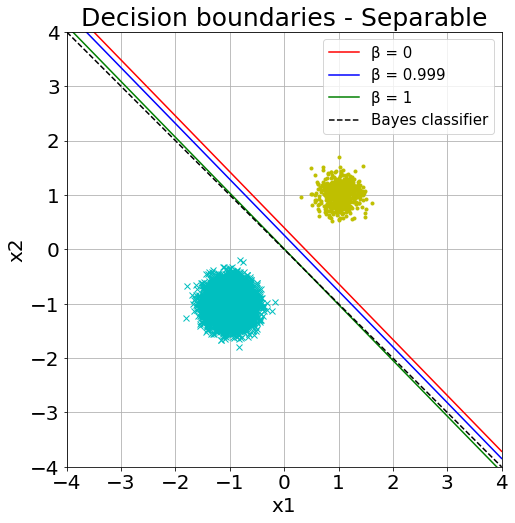

In [30]:
plt.plot(sampA[:,0], sampA[:,1], 'cx')
plt.plot(sampB[:,0], sampB[:,1], '.y')
plot_db(w0, w1, b0, b1, modelType='β = 0', lins='r')
plot_db(w0_cui, w1_cui, b0_cui, b1_cui, modelType=f'β = {beta}', lins='b')
plot_db(w0_bal, w1_bal, b0_bal, b1_bal, modelType='β = 1', lins='g')
plot_db([0,0], [1,1], 0, 0, modelType='Bayes classifier', lins='k--')
plt.legend(loc='best', fontsize=15)
plt.title('Decision boundaries - Separable', fontsize=25)
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('imbalSepWeighted.png', dpi=300)
plt.show()

Logit adjusted decision boundaries

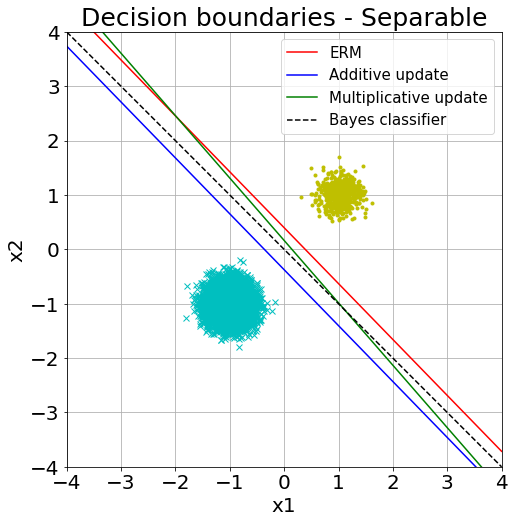

In [31]:
plt.plot(sampA[:,0], sampA[:,1], 'cx')
plt.plot(sampB[:,0], sampB[:,1], '.y')
plot_db(w0, w1, b0, b1, modelType='ERM', lins='r')
plot_db(w0, w1, b0_adjusted, b1_adjusted, modelType='Additive update', lins='b')
plot_db(w0_weighted, w1_weighted, b0_weighted, b1_weighted, modelType='Multiplicative update', lins='g')
plot_db([0,0], [1,1], 0, 0, modelType='Bayes classifier', lins='k--')
plt.legend(loc='best', fontsize=15)
plt.title('Decision boundaries - Separable', fontsize=25)
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('imbalSepUpdate.png', dpi=300)
plt.show()

Margin adjusted loss decision boundaries

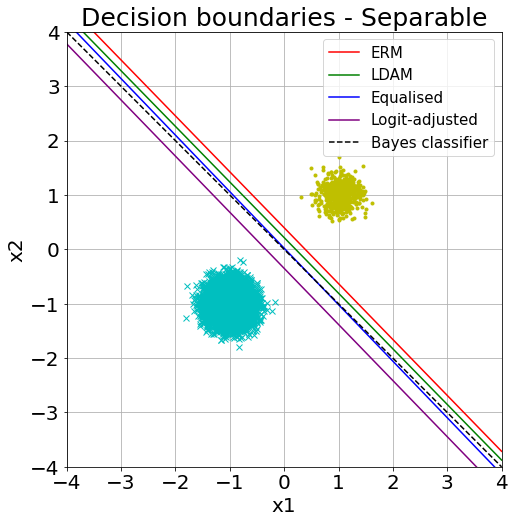

In [33]:
plt.plot(sampA[:,0], sampA[:,1], 'cx')
plt.plot(sampB[:,0], sampB[:,1], '.y')
plot_db(w0, w1, b0, b1, modelType='ERM', lins='r')
plot_db(w0_cao, w1_cao, b0_cao, b1_cao, modelType='LDAM', lins='g')
plot_db(w0_tan, w1_tan, b0_tan, b1_tan, modelType='Equalised', lins='b')
plot_db(w0_la, w1_la, b0_la, b1_la, modelType='Logit-adjusted', lins='purple')
plot_db([0,0], [1,1], 0, 0, modelType='Bayes classifier', lins='k--')
plt.legend(loc='best', fontsize=15)
plt.title('Decision boundaries - Separable', fontsize=25)
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('imbalSepMargin.png', dpi=300)
plt.show()